In [1]:
import torch
import torch.nn as nn
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.distributions.multivariate_normal import MultivariateNormal
import pickle
plt.rcParams["figure.figsize"] = (12,8)

In [2]:
from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal, ConditionalDiagonalNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [3]:
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self):
        with open('time_series_prts.pkl', 'rb') as f:
            data_ts = pickle.load(f)
            
        for t, prts in enumerate(data_ts):
            prts['t'] = t
        
        self.scaler = MinMaxScaler()
        
        context = []
        data = []
        for t in data_ts:
            data.append(t[['uz', 't']])

        data = pd.concat(data, ignore_index=True)
        data['uz'] = self.scaler.fit_transform(data[['uz']].values).astype(np.float32)
        self.data = data
        
    def __getitem__(self, i):
        return self.data[i]

    def __len__(self):
        return self.data.shape[0]

    def getData(self):
        #return self.scaler.inverse_transform(self.data.detach().numpy())
        return self.data
    
prt_data = ToyDataset()
data = prt_data.getData()
nbins = 100
hists = []
for t in range(21):
    prts = data[data['t'] == t]
    prts = prts['uz'].values
    hists.append( np.histogram(prts, bins=nbins, density=True, range=(0,1)) )



In [4]:
#k, h, d = 1, 32, 16 #two
#k, h, d = 1, 128, 4 #three
#k, h, d = 1, 8, 4 #four
k, h, d = 1, 64, 8 #five
f = 1
epochs = 1000


In [5]:

#base_dist = ConditionalDiagonalNormal(shape=[f], context_encoder=nn.Sequential(nn.Linear(1, 8), nn.Tanh(), nn.Linear(8, 2*f)))
base_dist = ConditionalDiagonalNormal(shape=[f], context_encoder=nn.Linear(21, 2*f))


transforms = []
for _ in range(d):
    transforms.append(ReversePermutation(features=f))
    transforms.append(MaskedAffineAutoregressiveTransform(features=f, 
                                                          hidden_features=h,
                                                          context_features=21))

transform = CompositeTransform(transforms)

# base_dist = MultivariateNormal( torch.ones(f), torch.eye(f) )

nf = Flow(transform, base_dist)
nf.load_state_dict(torch.load(f'/gpfs/alpine/proj-shared/fus137/johnd/nf-train/checkpoints_one_hot_full/checkpoint_877.pt', map_location=torch.device('cpu')))

#optimizer = torch.optim.Adam(nf.parameters())
nf.eval()
print('')

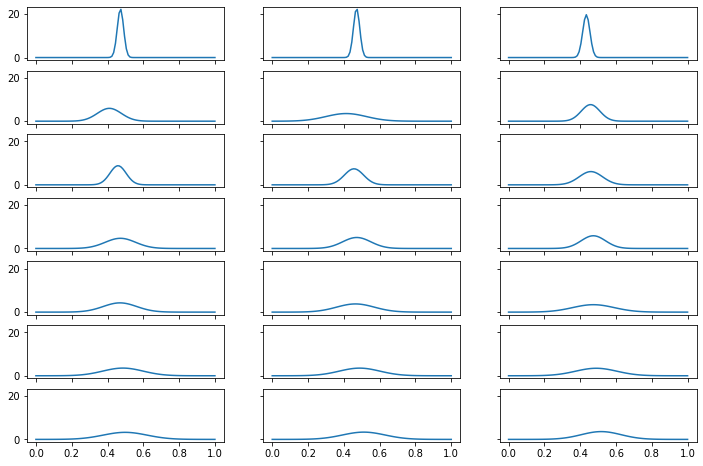

In [7]:
box = 1
xline = torch.linspace(0, box, nbins).reshape(-1,1)

zgrids = []
with torch.no_grad():
    for i in range(7):
        for j in range(3):
            c = np.zeros((xline.shape[0], 21), dtype=np.float32)
            c[:, i*3 + j] = 1
            zgrids.append( nf.log_prob(xline, context=c ) )
            #zgrids.append( np.histogram(nf.sample(1000, context=(i*3+j)*torch.ones((1, 1), dtype=torch.float32)).detach().numpy(), 30)[0])
    
fig, axes = plt.subplots(7, 3, sharex=True, sharey=True)
for i in range(7):
    for j in range(3):
        axes[i,j].plot(xline.numpy(), zgrids[i*3 + j].exp().numpy())
        #axes[i,j].plot(zgrids[i*3 + j])


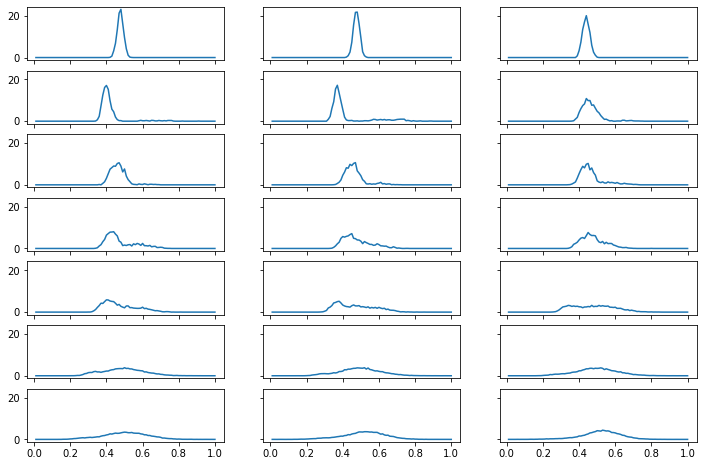

In [101]:
fig, axes = plt.subplots(7, 3, sharex=True, sharey=True)
for i in range(7):
    for j in range(3):
        axes[i,j].plot(hists[i*3+j][1][1:], hists[i*3 + j][0])
        


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[<matplotlib.lines.Line2D object at 0x7ffcbf032a20>, <matplotlib.lines.Line2D object at 0x7ffcbf032ac8>, <matplotlib.lines.Line2D object at 0x7ffcbf032b38>, <matplotlib.lines.Line2D object at 0x7ffcbf07f160>]


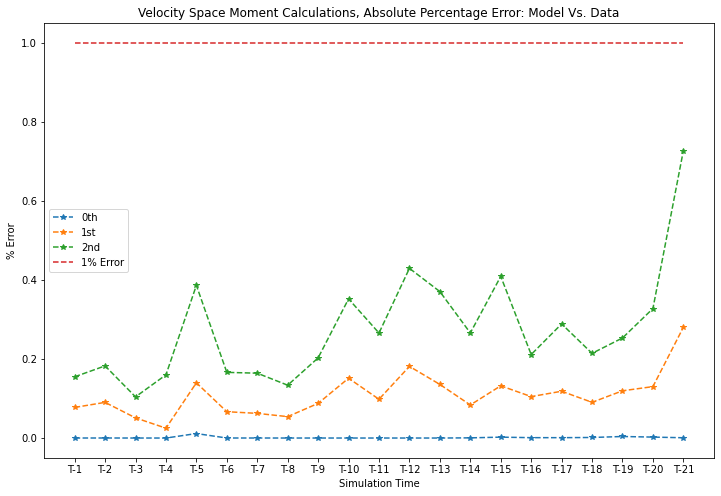

In [8]:
dx = np.diff(xline, axis=0)[0]

datas = []
mods = []
for pdf, (counts, bins) in zip(zgrids,hists):
    
    dx0 = np.diff(bins)
    v = 0.5*(bins[1:] + bins[:-1])
    datZero = np.sum(counts * dx0)
    datFirst = np.sum(counts * v * dx0)
    datSecond = np.sum(counts * v**2 * dx0)
    datas.append([datZero, datFirst,datSecond])
    
    v = xline.numpy().flatten()
    modZero = torch.sum(pdf.exp() * dx)
    modFirst = torch.sum(pdf.exp() * v * dx)
    modSecond = torch.sum(pdf.exp() * v**2 * dx)
    mods.append([modZero, modFirst, modSecond])
    
mData = np.array(datas)
mMod = np.array(mods)
errors = abs(mData - mMod) / mData
xtics = [f'T-{x}' for x in range(1,22)]

lines = plt.plot(xtics, errors * 100, '--*')

lines.append(plt.plot([1 for _ in errors], '--')[0])
print(lines)
plt.ylabel('% Error')
plt.legend(lines, ('0th', '1st', '2nd', '1% Error'))
plt.xlabel('Simulation Time')
plt.title('Velocity Space Moment Calculations, Absolute Percentage Error: Model Vs. Data')
plt.savefig('temporal-moments-error.eps')

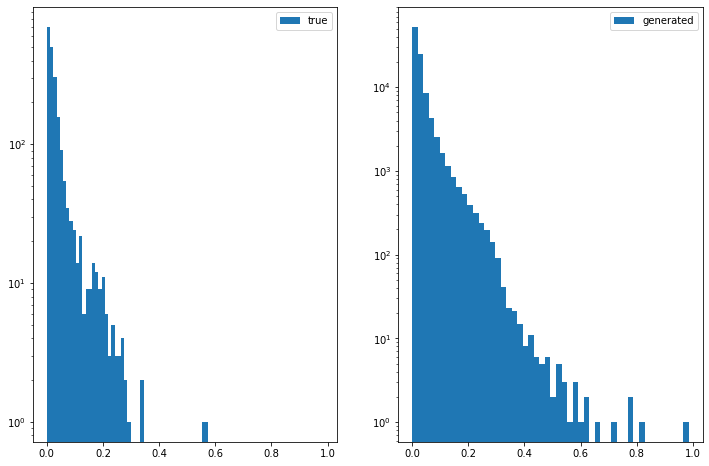

In [27]:
invsamp = prt_data.inverseScale(samples)
true = prt_data.inverseScale(prt_data.getData())
fig, axes = plt.subplots(1,2, sharex=True)
axes[0].hist(true[:,0]**2 + true[:,1]**2, 50, label='true')

axes[1].hist(invsamp[:,0]**2 + invsamp[:,1]**2, 50, label='generated')

for i in range(2):
    axes[i].set_yscale('log')
    axes[i].legend()

In [46]:
nbins = 20
dataHist, dataEdges = np.histogramdd(data, bins=(nbins,nbins), density=True)

In [47]:
sampleHist, sampleEdges = np.histogramdd(samples, bins=dataEdges, density=True)

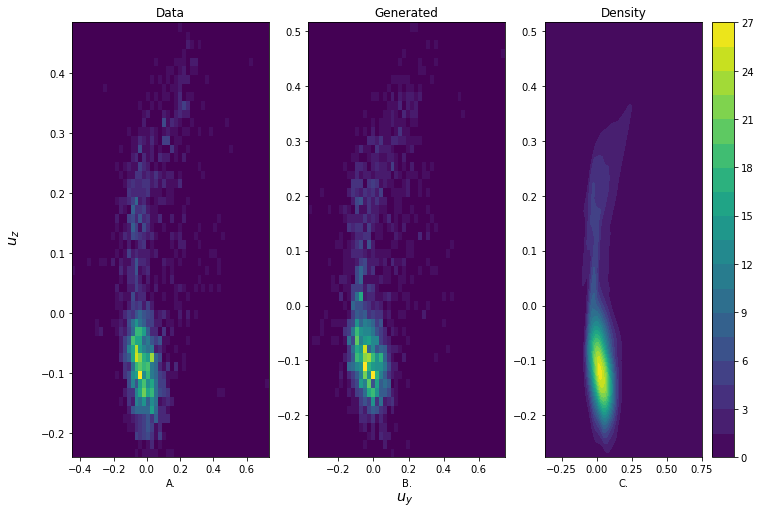

In [80]:
fig, axes = plt.subplots(1,3)
#axes[0].pcolormesh(dataHist.T, label='data')
#axes[1].pcolormesh(sampleHist.T, label='generated')
axes[0].hist2d(true[:,0], true[:,1], nbins)
axes[1].hist2d(invsamp[:,0],invsamp[:,1], nbins)
xline = np.linspace(invsamp[:,0].min(), invsamp[:,0].max(), 100)
yline = np.linspace(invsamp[:,1].min(), invsamp[:,1].max(), 100)
xgrid, ygrid = np.meshgrid(xline, yline)
df = axes[2].contourf(xgrid, ygrid, zgrid.exp().numpy().T, 20)
axes[0].set_title('Data')
axes[1].set_title('Generated')
axes[2].set_title('Density')
axes[0].set_xlabel('A.')
axes[1].set_xlabel('B.')
axes[2].set_xlabel('C.')
fig.text(0.05, 0.5, r'$u_z$', rotation='vertical', fontsize='x-large')
fig.text(0.5, 0.05, r'$u_y$', rotation='horizontal', fontsize='x-large')
fig.colorbar(df, ax=axes[2])
fig.savefig('submission/density-estimation.pdf')

Text(0.5, 1.0, 'data hist')

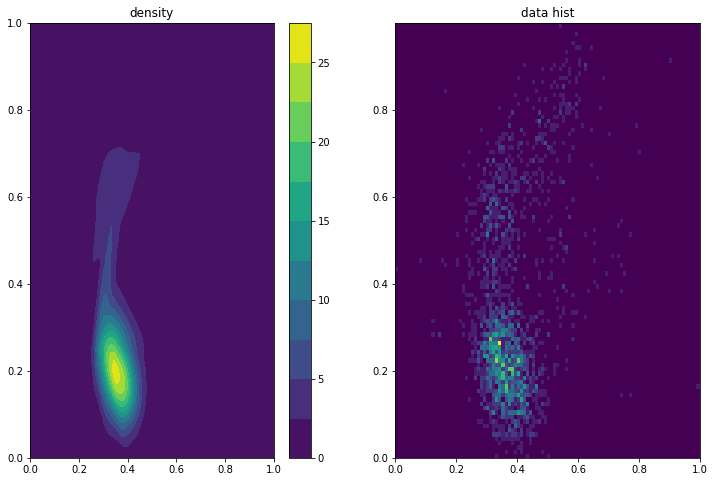

In [37]:
fig, axes = plt.subplots(1,2)
cf = axes[0].contourf(xgrid.numpy(), ygrid.numpy(), zgrid.exp().numpy(), 10)
axes[0].set_title('density')
fig.colorbar(cf, ax=axes[0])

h = axes[1].hist2d(data[:,0], data[:,1], bins=100)
axes[1].set_title('data hist')
#fig.colorbar(h[0], ax=axes[1])